In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import time
import json
import random
import numpy as np
import pandas as pd
import itertools
import scipy
import gc
import cv2

from pathlib import Path
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import colors as colors_mat
from scipy.ndimage import label, generate_binary_structure
from numpy.lib.stride_tricks import as_strided
from itertools import product
from scipy.spatial.distance import cdist
from scipy.signal import convolve2d
from collections import Counter

In [3]:
start_time = time.time()
print("Load Initial Data ...")

data_path = Path('')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
testing_path = data_path / 'test'

training_tasks = sorted(os.listdir(training_path))
evaluation_tasks = sorted(os.listdir(evaluation_path))
testing_tasks = sorted(os.listdir(testing_path))
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='output_id')

print("--- %s seconds ---" % (time.time() - start_time))

Load Initial Data ...
--- 0.020716190338134766 seconds ---


In [4]:
start_time = time.time()
print("Load Data Functions ...")

def flattener(pred):
    
    str_pred = str([row for row in pred.tolist()])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    
    return str_pred

def build_tasklist(task):
    
    task_data = []
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]).astype('uint8'), np.array(t["output"]).astype('uint8')        
        list.append(task_data, (t_in.copy(), t_out.copy()))
    
    return task_data

def build_testlist(task):
    
    task_data = []
    for i, t in enumerate(task["test"]):
        t_in = np.array(t["input"]).astype('uint8')       
        list.append(task_data, (t_in.copy()))
    
    return task_data

def load_data(p, phase=None):
    
    if phase in {'training', 'test', 'evaluation'}:
        p = data_path / phase / p
    
    task = json.loads(Path(p).read_text())
    dict_vals_to_np = lambda x: { k : np.array(v) for k, v in x.items() }
    assert set(task) == {'test', 'train'}
    res = dict(test=[], train=[])
    
    for t in task['train']:
        assert set(t) == {'input', 'output'}
        res['train'].append(dict_vals_to_np(t))
    for t in task['test']:
        res['test'].append(dict_vals_to_np(t))
        
    return res

print("--- %s seconds ---" % (time.time() - start_time))

Load Data Functions ...
--- 0.0005879402160644531 seconds ---


In [5]:
start_time = time.time()
print("Load Data Files ...")

train_task_data = []
for i in range(0, 400):
    task = load_data(training_tasks[i], phase='training')
    list.append(train_task_data, task)

eval_task_data = []
for i in range(0, 400):
    task = load_data(evaluation_tasks[i], phase='evaluation')
    list.append(eval_task_data, task)

test_task_data = []
for i in range(0, 100):
    task = load_data(testing_tasks[i], phase='test')
    list.append(test_task_data, task)
    
print("--- %s seconds ---" % (time.time() - start_time))

Load Data Files ...
--- 2.464783191680908 seconds ---


In [6]:
start_time = time.time()
print("Load Checking Functions")

cmap = colors_mat.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors_mat.Normalize(vmin=0, vmax=9)
num2color = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]
color2num = {c: n for n, c in enumerate(num2color)}

def plot_one(task, ax, i,train_or_test,input_or_output):
    
    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' '+ input_or_output)
    
def plot_task(task):

    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(task, axs[0,i],i,'train','input')
        plot_one(task, axs[1,i],i,'train','output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test==1: 
        plot_one(task, axs[0],0,'test','input')
        plot_one(task, axs[1],0,'test','output')     
    else:
        for i in range(num_test):      
            plot_one(task, axs[0,i],i,'test','input')
            plot_one(task, axs[1,i],i,'test','output')  
    plt.tight_layout()
    plt.show()

def check_p(task, pred_func):
    
    fig_num = 0
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(3, n, figsize=(4*n,12), dpi=50)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # All Data for Task
    task_data = build_tasklist(task)
    test_data = build_testlist(task)
    pattern = Pattern(task_data, test_data)
    
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]).astype('uint8'), np.array(t["output"]).astype('uint8')   
        entity = Entity(t_in, t_out)
        t_pred = t_in
        
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        axs[2][fig_num].imshow(t_pred, cmap=cmap, norm=norm)
        axs[2][fig_num].set_title(f'Train-{i} pred')
        axs[2][fig_num].set_yticks(list(range(t_pred.shape[0])))
        axs[2][fig_num].set_xticks(list(range(t_pred.shape[1])))
        fig_num += 1
        
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]).astype('uint8'), np.array(t["output"]).astype('uint8')
        t_pred = t_in
        
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        axs[2][fig_num].imshow(t_pred, cmap=cmap, norm=norm)
        axs[2][fig_num].set_title(f'Test-{i} pred')
        axs[2][fig_num].set_yticks(list(range(t_pred.shape[0])))
        axs[2][fig_num].set_xticks(list(range(t_pred.shape[1])))
        fig_num += 1

print("--- %s seconds ---" % (time.time() - start_time))

Load Checking Functions
--- 0.003253936767578125 seconds ---


In [7]:
start_time = time.time()
print("Load DSL Helper Functions (Main)")

def get_neighbors(task, i, j):
    
    nbh = lambda x, i, j: { 
        (ip, jp) : x[i+ip, j+jp] 
            for ip, jp in product([1, -1, 0], repeat=2) 
                if 0 <= i+ip < x.shape[0] and 0 <= j+jp < x.shape[1]
    }
        
    nbh_data = nbh(task, i, j)
    nbh_values = [(1, 1), (1, -1), (1, 0), (-1, 1), (-1, -1), 
                  (-1, 0), (0, 1), (0, -1), (0, 0)]

    for val in nbh_values:
        if val not in nbh_data:
            nbh_data[val] = 0
    
    return nbh_data

def get_background_color(task):
    
    background_color = 0
    cnt = np.bincount(task.flatten())[1:]
    bg_color = [i + 1 for i, x in enumerate(cnt) if x == max(cnt)][0]
    if np.nonzero(cnt)[0].shape[0] >= 2:
        if max(cnt) >= (task.shape[0] * task.shape[1] * 0.25):
            background_color = bg_color

    return background_color    
    
print("--- %s seconds ---" % (time.time() - start_time))

Load DSL Helper Functions (Main)
--- 0.000865936279296875 seconds ---


In [8]:
start_time = time.time()
print("Load DSL Helper Functions (Detection)")
       
# Separate Objects in Task
def object_detection(task):
    
    # List of Objects
    object_list = []
    task_copy = task.copy()
    struct = generate_binary_structure(2, 2)
    
    # Ensure Colors != Background
    task_colors = np.unique(task_copy)
    bg_color = get_background_color(task_copy)
    task_colors = [col for col in task_colors if col != bg_color]

    # Find Objects
    for color in task_colors:
        labels, num_labels = label((task_copy == color), structure=struct)
        for i in range(0, num_labels):
            idx = np.column_stack(np.where(labels == i + 1))
            x_min = min([point[0] for point in idx])
            y_min = min([point[1] for point in idx])
            x_max = max([point[0] for point in idx])
            y_max = max([point[1] for point in idx])

            object_data = {}
            object_data['coords'] = idx
            object_data['obj'] = task_copy[x_min: x_max + 1, y_min: y_max + 1]
            list.append(object_list, object_data)
        
    return object_list
        
# Separate Layers in Task
def layer_detection(task):
    
    # List of Layers
    layer_list = []
    task_copy = task.copy()
    task_colors = np.unique(task_copy)

    # Find Layers by Color
    for color in task_colors:
        layer_copy = task_copy.copy()
        layer_copy[layer_copy != color] = 0
        
        layer_data = {}
        layer_data['layer'] = layer_copy
        list.append(layer_list, layer_data)
        
    return layer_list
        
def region_detection(task):
    
    # List of Regions
    region_list = []
    task_copy = task.copy()

    # Ensure Colors != Background
    task_colors = np.unique(task_copy)
    bg_color = get_background_color(task_copy)
    task_colors = [col for col in task_colors if col != bg_color]
    
    # Find Regions by Looking for Horizontal/Vertical Lines
    # Typically, there won't be any overlap between region lines/object colors
    for color in task_colors:
        
        # Declare Splits
        vertical_splits = None
        horizontal_splits = None

        # Vertical Regions
        vertical_partition = np.zeros((task_copy.shape[0], 1))       
        vertical_partition[:, 0] = color
        vertical_result = cv2.matchTemplate(
            task_copy.astype(np.uint8), vertical_partition.astype(np.uint8), cv2.TM_SQDIFF)
        vertical_positions = np.argwhere(vertical_result < 0.001)

        # Horizontal Regions
        horizontal_partition = np.zeros((1, task_copy.shape[1]))       
        horizontal_partition[0, :] = color
        horizontal_result = cv2.matchTemplate(
            task_copy.astype(np.uint8), horizontal_partition.astype(np.uint8), cv2.TM_SQDIFF)
        horizontal_positions = np.argwhere(horizontal_result < 0.001)
        
        # Check if Horizontal/Vertical Partitions Exist
        if (len(vertical_positions) >= 1) or (len(horizontal_positions) >= 1):
            
            # Combine Vertical/Horizontal Regions
            vertical_splits = [-1] + [x[1] for x in vertical_positions]
            horizontal_splits = [-1] + [x[0] for x in horizontal_positions]

            # Get Vertical Split Ranges
            for i, v_split in enumerate(vertical_splits):
                end_split_i = None
                start_split_i = vertical_splits[i]
                if i + 1 == len(vertical_splits):
                    end_split_i = task_copy.shape[0]
                else:
                    end_split_i = vertical_splits[i + 1]

                # Get Horizontal Split Ranges
                for j, h_split in enumerate(horizontal_splits): 
                    end_split_j = None
                    start_split_j = horizontal_splits[j]
                    if j + 1 == len(horizontal_splits):
                        end_split_j = task_copy.shape[1]
                    else:
                        end_split_j = horizontal_splits[j + 1]

                    idx = []
                    for i in range(start_split_i + 1, end_split_i):
                        for j in range(start_split_j + 1, end_split_j):
                            list.append(idx, [i, j])

                    region_data = {}
                    region_data['coords'] = np.array(idx)
                    region_data['region'] = task_copy[start_split_j + 1: end_split_j, start_split_i + 1: end_split_i]
                    list.append(region_list, region_data)

    return region_list
    
print("--- %s seconds ---" % (time.time() - start_time))

Load DSL Helper Functions (Detection)
--- 0.0014188289642333984 seconds ---


In [9]:
start_time = time.time()
print("Load DSL Helper Functions (Attributes)")

# def object_attributes(object_list):
    # Returns Attributes for Dict

# def layer_attributes(layer_list):
    # Returns Attributes for Dict

# def region_attributes(region_list):
    # Returns Attributes for Dict

print("--- %s seconds ---" % (time.time() - start_time))

Load DSL Helper Functions (Attributes)
--- 0.0003619194030761719 seconds ---


In [10]:
start_time = time.time()
print("Load DSL Helper Functions (Entity)")

class Pattern():
    
    def __init__(self, task_data, test_data):
        
        # Current Pattern/Data
        self.pattern = None
        self.task_data = task_data
        self.test_data = test_data

    def check_pattern():
        pass
        
class Entity():
    
    def __init__(self, task, output):
        
        # Current Task/Data
        self.task = task
        self.output = output
        self.diff = output - task
        self.diff[self.diff != 0] = 1
        
        # Components of Task
        self.task_objects = object_detection(task)
        self.task_layers = layer_detection(task)
        self.task_regions = region_detection(task)
        self.task_attributes = {
            "objects": "",
            "layers": "",
            "regions": "",
        }
                               
print("--- %s seconds ---" % (time.time() - start_time))

Load DSL Helper Functions (Entity)
--- 0.00035500526428222656 seconds ---


Testing DSL Coverage (Manual) ...
--- 0.4574708938598633 seconds ---


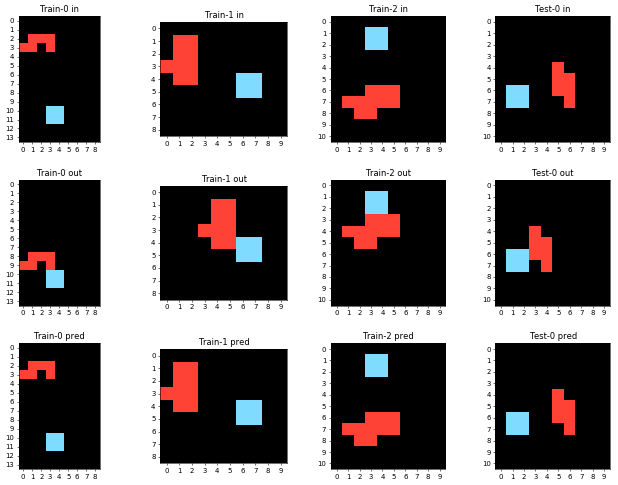

In [11]:
start_time = time.time()
print("Testing DSL Coverage (Manual) ...")

def combine_tasks(a, features):
    b = a.copy()
    return b

tasks_indices = [7]
for task in tasks_indices:
    check_p(train_task_data[task], combine_tasks)

print("--- %s seconds ---" % (time.time() - start_time))